# Support Vector Machine --- Predict Failure Mode #
# UCI dataset "AI4I 2020 Predictive Maintenance Dataset Data Set" #

Online-Source [here](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset#)

 AI4I 2020 Predictive Maintenance Dataset Data Set
Download: Data Folder, Data Set Description

Abstract: The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

| | | | | | |	
|:---|:---:|:---|:---:|:---|:---:|
|Data Set Characteristics: |Multivariate, Time-Series |Number of Instances: |10.000 |Area: |Computer |
|Attribute Characteristics: |Real |Number of Attributes: |14 | Date Donated: | 2020-08-30 |
|Associated Tasks: | Classification, Regression, Causal-Discovery | Missing Values? |N\A|Number of Web Hits: | 16614 |


Source:

Stephan Matzka, School of Engineering - Technology and Life, Hochschule für Technik und Wirtschaft Berlin, 12459 Berlin, Germany, stephan.matzka '@' htw-berlin.de

Data Set Information:

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge.




Attribute Information:

The dataset consists of 10 000 data points stored as rows with 14 features in columns <br>
<b> UID : </b> unique identifier ranging from 1 to 10000<br>
<b> product ID: </b>consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number <br>
<b> air temperature [K]: </b> generated using a random walk process later normalized to a standard deviation of 2 K around 300 K <br>
<b> process temperature [K]: </b> generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K. <br>
<b> rotational speed [rpm]: </b> calculated from a power of 2860 W, overlaid with a normally distributed noise <br>
<b> torque [Nm]: </b> torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. <br>
<b> tool wear [min]: </b> The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true. <br>

The machine failure consists of five independent failure modes <br>
<b> tool wear failure (TWF): </b> the tool will be replaced or fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned). <br>
<b> heat dissipation failure (HDF): </b> heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points. <br>
<b> power failure (PWF): </b> the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset. <br>
<b> overstrain failure (OSF): </b> if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints. <br>
<b> random failures (RNF): </b> each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.<br>
<br>
If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

Relevant Papers:

Stephan Matzka, 'Explainable Artificial Intelligence for Predictive Maintenance Applications', Third International Conference on Artificial Intelligence for Industries (AI4I 2020), 2020 (in press)


Citation Request:

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

# <b> What is done in this notebook? </b> #
Every data record contains information on the failure and the failure mode.
In this notebook we try to predict, which failure mode applies to a given record.

To this end we chose a subset of features of the dataset and use:
1. a support vector machine


## Plan: ##
1. enhance the failue modes by a new one: NOF - no failure. Thus a predictor has the possibility to move probability mass to this mode in case of no failure.
2. try different Support Vector Machines:
<br>2.1 Linear SVM
<br>2.2 RBF SVM
3. determine the best parameters for the SVC measured by AUC via grid-search <br>
Planed:
4. compare with random-search
5. build a voting classifier from several such SVM's
6. combine (probably in a new notebook) SVM's and decision-trees in a voting classifier


## Accuracy is not the correct metric ##
Machine failure is a rare event, i.e. accuracy is no meaningful performace-measure since a classifier allways predicting "No Machine Failure" will have a high accurcy without being usefull at all.<br>
We use:<br>
+ AUC area under (ROC) curve ---


In [154]:
%reset -f

In [155]:
import pandas as pd
import os
from pathlib import Path
import numpy as np

In [156]:
# define a dictionary to collect all relevant results on the way:
#=================================================================
REPORT = {}

In [157]:
# READ THE DATASET INTO A DATAFRAME:
# ==================================

# use absolute path:

#base_path = Path("C:/Users/BoSc/Documents/1000_Machine_Learning/1000_UCI_datasets/predictive_maintenance_dataset")
#csv_data_file_path = Path("/dataset/ai4i2020.csv")
#df = pd.read_csv(os.path.join(base_path, csv_data_file_path))

# use path relative to the notebook:

csv_data_file_path = Path("./dataset/ai4i2020.csv")
df = pd.read_csv(csv_data_file_path)

REPORT["csv_data_file_path"] = "./dataset/ai4i2020.csv"

In [158]:
# TAKE A LOOK AT THE DATA:
# ========================

df[:3]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


## Data and Target Preparation: ##
### predictive columns - a selection of columns believed to have some predictive power <br> ###
### target columns - the columns to be predicted ###

In [159]:
# chose dealing with only one quality-type (l, h, m) or all:
#===========================================================
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

equipment_type = 'all'
#equipment_type = 'L'
#equipment_type = 'M'
#equipment_type = 'H'

REPORT["equipment_type"] = equipment_type

data_columns = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Machine failure',
    'TWF',
    'HDF', 
    'PWF', 
    'OSF',
    'RNF',
    ]

if(equipment_type != 'all'):
    df_ = df[df['Type']== equipment_type]
else:
    # manual dummy-encoding of the type column:
    df_ = df
    df_type = df['Type']
    df_type = df_type.values.reshape(-1,1)
    enc = OneHotEncoder(sparse=False)
    ohe_type= enc.fit_transform(df_type)
    df_.insert(0, "L", ohe_type[:,1])
    data_columns.insert(0,"L")
    df_.insert(1, "M", ohe_type[:,2])
    data_columns.insert(1, "M")
    df_.insert(2, "H", ohe_type[:,0])
    data_columns.insert(2, "H")
    '''
    # dummy-encoding using make_column_transformer:
    # ... the ohe delivers '0.0' and '1.0' instead of "0" and "1", causing
    # some problems with conversion to "numeric" encoding of the categories.
    
    df_= df.drop(['UDI', 'Product ID'], axis=1)
    data_columns = np.insert(data_columns,0,['L', 'M', 'H'])
    ohe = OneHotEncoder(categories=[['L', 'M', 'H']])
    ct = make_column_transformer(
        (ohe, ['Type']),
        remainder='passthrough'
    )
    df_ = pd.DataFrame(data=ct.fit_transform(df_), columns=data_columns)
    '''

data_df = df_[data_columns]
REPORT["data_columns"] = data_columns
data_df[:3]

,L,M,H,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0.0,1.0,0.0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,1.0,0.0,0.0,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,1.0,0.0,0.0,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [160]:
# PREPARE DATA AND LABELS:
# ========================

from sklearn.model_selection import train_test_split

# predictive columns:
predictive_columns = data_columns[:-6]
X = data_df[predictive_columns]

# target columns:
target_columns = data_columns[-6:]
y = data_df[target_columns]


In [161]:
# Some sanity-check of the data to avoid single-class training-/test-sets:
#=========================================================================
mf_y = np.asarray(y['Machine failure']==1).sum()

# check if there are some records for machine-failure in the data:
print(f"There are approximately {mf_y}, i.e. {100 *mf_y / len(y)}%, records for machine failure in the data: ")

There are approximately 339, i.e. 3.39%, records for machine failure in the data: 


In [162]:
# Train-test split of the data:

test_size=0.2
REPORT["test_size"] = test_size

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=test_size)
print(f"X.shape: {X.shape}")
REPORT["X.shape"]= X.shape
print(f"y.shape: {y.shape}")
REPORT["y.shape"]=y.shape
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")
print(f"predictive_columns: {predictive_columns}")
print(f"target_columns: {target_columns}")


X.shape: (10000, 8)
y.shape: (10000, 6)
X_train.shape: (8000, 8)
y_train.shape: (8000, 6)
X_test.shape: (2000, 8)
y_test.shape: (2000, 6)
predictive_columns: ['L', 'M', 'H', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
target_columns: ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [163]:
# Some sanity-check of the data to avoid single-class training-/test-sets:
#=========================================================================
mf_train = np.asarray(y_train['Machine failure'] == 1).sum()
mf_test = np.asarray(y_test['Machine failure'] == 1).sum()

# check if there are some records for machine-failure in the data:
print(f"There are approximately {mf_train}, i.e. { 100 * mf_train / len(y_train)} %, machine-failure records in the train set")
print(f"There are approximately {mf_test}, i.e. {100 * mf_test / len(y_test)}%, machine-failure records in the test set")

There are approximately 264, i.e. 3.3 %, machine-failure records in the train set
There are approximately 75, i.e. 3.75%, machine-failure records in the test set


# Support Vector Machine: #

In [165]:
# helper function an maps to convert back and forth between :
# OHE encoding, 
# numeric categorial encoding, 
# string categorial encoding:
#=====================================================================================================================

def OheToSingleCodedModes(ohe_labels, code="named"):
    """
        The failure-modes are OHE or rather (More-than-one-hot-) encoded.
        This function encodes them as integers (code="numeric") or like the column names (code="named"), 
        but takes only single-mode machine-failures correctly into account.
        Multi-mode machine-failures are jointly encoded as "Multimode".
        
        Input:
            ohe_labels: an array of arrays of zero and ones ex.: [[1,1,0,0,0,0],[1,0,0,0,1,0]]
            code: target encoding - default = "named"=column names of the original dataframe, 
                                    "numeric" = integers
        Output:
            an array of integers.
    """
    coded_modes = []
    if(code == "numeric"):
        # build a mode dictionary for the standard failure modes (given in the explantion above). 
        # No multi-mode failures are accounted for:
        modes = {"".join(map(str,[0,0,0,0,0,0])): 0, #'No Machine failure',
            "".join(map(str,[1,1,0,0,0,0])): 1, #'TWF',
            "".join(map(str,[1,0,1,0,0,0])): 2, #'HDF', 
            "".join(map(str,[1,0,0,1,0,0])): 3, #'PWF', 
            "".join(map(str,[1,0,0,0,1,0])): 4, #'OSF',
            "".join(map(str,[0,0,0,0,0,1])): 5,#'RNF',
        }
        # machine failures consisting of multiple modes are designated as "Multimode":
        for v in ohe_labels:
            coded_modes.append(modes.get("".join(map(str,v)), 6)) # 6  =="Multimode"
    else:
        modes = {"".join(map(str,[0,0,0,0,0,0])): 'No Machine failure',
            "".join(map(str,[1,1,0,0,0,0])): 'TWF',
            "".join(map(str,[1,0,1,0,0,0])): 'HDF', 
            "".join(map(str,[1,0,0,1,0,0])): 'PWF', 
            "".join(map(str,[1,0,0,0,1,0])): 'OSF',
            "".join(map(str,[0,0,0,0,0,1])): 'RNF',
        }
        # machine failures consisting of multiple modes are designated as "Multimode":
        for v in ohe_labels:
            coded_modes.append(modes.get("".join(map(str,v)),"Multimode")) 

    return np.array(coded_modes)

# clear mode dictionary:
clear_modes =  {
    0 : 'No Machine failure',
    1 : 'TWF',
    2 : 'HDF', 
    3 : 'PWF', 
    4 : 'OSF',
    5 : 'RNF',
    6 : "Multimode",
}

modes_OHE = {
    0 : [0,0,0,0,0,0], # 'No Machine failure
    1 : [1,1,0,0,0,0], # 'TWF'
    2 : [1,0,1,0,0,0], # 'HDF' 
    3 : [1,0,0,1,0,0], # 'PWF' 
    4 : [1,0,0,0,1,0], # 'OSF'
    5 : [0,0,0,0,0,1], # 'RNF'
    6 : [1,1,1,0,0,0], # 'Multimode'
}

## Try a linear Support Vector Classifier first ##

In [166]:
# encode the targets:
#--------------------

y_train_num = OheToSingleCodedModes(y_train.values, code="numeric")
y_test_num = OheToSingleCodedModes(y_test.values, code="numeric")


In [ ]:
# DEFINE AND FIT a Polynomial Support Vector Machine:
# ===================================================

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVC

poly_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=1, loss='hinge', max_iter=1000, class_weight='balanced'))
    ])

poly_svm_clf.fit(X_train,y_train_num)


C:\Users\BoSc\anaconda3\envs\decTrees\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=1, class_weight='balanced', loss='hinge'))])

## Conclusion: ##
The LinearSVC does not converge onto a solution. Even a polynomial feature transformation does not help. <br>
Options: <br>
1. increase number of iterations: default= 1000, 1st trial=5000, 2nd trial=10000 -- no convergence for any of them
2. smaller C parameter, to allow more margin violations
3. higher order polynomials

## Try a SVC with a radial basis function (rbf) ##

In [169]:
# Single SVC:
#============
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC

rbf_svm_clf = Pipeline([
    ('scaler', StandardScaler()), 
    ('rbf_clf', SVC(kernel="rbf", C=0.01, gamma='auto' , probability=True, class_weight='balanced', random_state=11))
    ])

rbf_svm_clf.fit(X_train, y_train_num)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rbf_clf',
                 SVC(C=0.01, class_weight='balanced', gamma='auto',
                     probability=True, random_state=11))])

In [ ]:
# MEAN ACCURACY ON THE TEST DATA:
# ===============================

# this does not say much, since we have mainly "0" as labels:
mean_acc = rbf_svm_clf.score(X_test, y_test_num)
REPORT["mean acc single SVC test-data:"]=mean_acc
print(f"\n Mean accuracy test: {mean_acc}")
mean_acc = rbf_svm_clf.score(X_train, y_train_num)
REPORT["mean acc single SVC train-data:"]=mean_acc
print(f"\n Mean accuracy train: {mean_acc}")



 Mean accuracy test: 0.758

 Mean accuracy train: 0.754625


As we expected from the strong imbalance of the data-set, the accuracy is quite high. <br>
It is better to measure the predictive powers of the machine with ROC-AUC instead:

In [ ]:
# ROC-AUC METRIC FOR DATASET WITH CLASS IMBALANCE:
#=================================================
# see e.g.:Data School vid on roc auc: https://youtu.be/OAl6eAyP-yo

from sklearn.metrics import roc_auc_score

y_preds_proba = rbf_svm_clf.predict_proba(X_test)
auc=roc_auc_score(y_test_num, y_preds_proba, multi_class='ovo')
REPORT["auc single rbf estimator"]=auc

print(f"\n Area Under the Curve (auc): {auc}")


 Area Under the Curve (auc): 0.7818974054049106


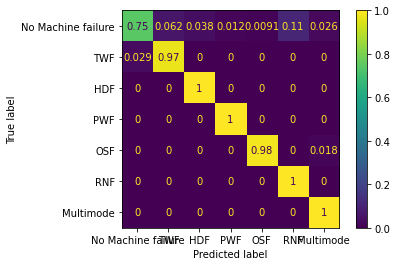

In [ ]:
# Plot Confusion Matrix:
#=======================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# classifier to use:
#-------------------
classifier = rbf_svm_clf

# prediction on test data:
#-------------------------
# y_preds_num = classifier.predict(X_test)
# true_modes = OheToSingleCodedModes(y_test.values, code="named")

# prediction on training data:
#-----------------------------
y_preds_num = classifier.predict(X_train)
true_modes = OheToSingleCodedModes(y_train.values, code="named")

# convert numeric preds to named preds for use in conf. matrix:
#--------------------------------------------------------------
y_preds_ohe = [modes_OHE[y] for y in y_preds_num]
pred_modes = OheToSingleCodedModes(y_preds_ohe, code="named")

labels = ['No Machine failure','TWF','HDF','PWF','OSF','RNF',"Multimode"]
cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="true") # row - normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="pred") # column -normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="all") # over all entries - normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize=None) # absolute numbers
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
#disp.ax_.set_title(f"Equipment type: {equipment_type}") # seems to be possible in scikit v1.0
disp.plot()


In [32]:
# consider f1_score as metric:
#=============================

from sklearn.metrics import f1_score

y_preds_num = rbf_svm_clf.predict(X_test)

f1 = f1_score(y_test_num, y_preds_num, average='weighted')
print(f'weighted f1-score: {f1}')
REPORT['weighted f1-score single rbf'] = f1
f1 = f1_score(y_test_num, y_preds_num, average='macro')
print(f'macro-averaged f1-score: {f1}')
REPORT['macro-averaged f1_score single rbf'] = f1

y_test_OHE = [modes_OHE[y] for y in y_test_num]
y_preds_OHE = [modes_OHE[y] for y in y_preds_num]
f1 = f1_score(y_test_OHE, y_preds_OHE, average='samples', zero_division=1)
print(f'samples-averaged f1-score: {f1}')
REPORT['samples-averaged f1_score single rbf'] = f1

weighted f1-score: 0.841004454665346
macro-averaged f1-score: 0.3444181734853156
samples-averaged f1-score: 0.7597


# Parameter Search via GridSearchCV #

In [66]:
# grid search for the most convenient parameters:
#================================================
# parameters are: C and gamma
# Caveats:
# 1. this solution has very high run-time, even with no parameters, like: param_grid={'C':[1]}, - which is the default for all SVC. Why?
# 2. this might be caused by the class_weight='balanced' parameter.
# 3. the auc is worse than the same model without grid-search.
#
# Answer to all this: You forgot the standard scaler, stupid ! -- too see the difference caused soleily by this:
# compare the confusion-matrices "svc_rbf_grid_classweights_balanced.png" and "svc_rbf_grid_classweights_balanced_NoScaler.png"

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

svc_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svc_clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=11))
])

clf = GridSearchCV(estimator=svc_pipe, 
        param_grid={'svc_clf__C':[0.01, 0.001], 'svc_clf__gamma':['auto', 'scale']}, # run-time: 21m 13.7s
        scoring=roc_auc_score,
        n_jobs=-1,
        )

clf.fit(X_train, y_train_num)

best_clf = clf.best_estimator_

y_preds_prob = best_clf.predict_proba(X_test)
auc = roc_auc_score(y_test_num, y_preds_prob, multi_class='ovo')
REPORT["auc best estimator"]=auc

print(f"\n Area Under the Curve (auc): {auc}")


C:\Users\BoSc\anaconda3\envs\decTrees\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(



 Area Under the Curve (auc): 0.7752785039421403


In [117]:
# Save the model to disk:
#========================

from joblib import dump, load

filename = 'best_clf_0775.joblib'
#dump(best_clf, filename)

# load:
best_clf = load(filename)

# for further and more advanced persistence options:
# Scikit Docu : https://scikit-learn.org/stable/modules/model_persistence.html
# Joblib Docu : https://joblib.readthedocs.io/en/latest/persistence.html
# Nueraxle : https://www.neuraxle.org/
# ONNX : https://onnx.ai/

In [118]:
# Parameters of the best classifier from Gridsearch:
#===================================================

params = best_clf.get_params()

print('Parameters of best classifier:')
print(f"svc_clf: {params['svc_clf']}")
print(f"C: {params['svc_clf__C']}")
print(f"gamma: {params['svc_clf__gamma']}")
#Scorer Funktion!

Parameters of best classifier:
svc_clf: SVC(C=0.01, class_weight='balanced', gamma='auto', probability=True,
    random_state=11)
C: 0.01
gamma: auto


In [69]:
clf.best_params_

{'svc_clf__C': 0.01, 'svc_clf__gamma': 'auto'}

# Experiments: #
1. 'svc_clf': SVC(C=0.1, class_weight='balanced', gamma='auto', probability=True, random_state=11), Area Under the Curve (auc): 0.7879983609815762
2. 'svc_clf': SVC(C=0.01, class_weight='balanced', gamma='auto', probability=True, random_state=11), Area Under the Curve (auc): 0.7752785039421403

In [119]:
# consider f1_score as metric:
#=============================

from sklearn.metrics import f1_score

y_preds_num_best = best_clf.predict(X_test)

f1 = f1_score(y_test_num, y_preds_num_best, average='weighted')
print(f'weighted f1-score: {f1}')
REPORT['weighted f1-score best rbf'] = f1
f1 = f1_score(y_test_num, y_preds_num_best, average='macro')
print(f'macro-averaged f1-score: {f1}')
REPORT['macro-averaged f1_score best rbf']=f1

y_test_OHE = [modes_OHE[y] for y in y_test_num]
y_preds_OHE = [modes_OHE[y] for y in y_preds_num_best]
f1 = f1_score(y_test_OHE, y_preds_OHE, average='samples', zero_division=1)
print(f'samples-averaged f1-score: {f1}')
REPORT['samples-averaged f1_score best rbf'] = f1


NameError: name 'X_test' is not defined

In [51]:
print(REPORT)

{'csv_data_file_path': './dataset/ai4i2020.csv', 'equipment_type': 'all', 'data_columns': ['L', 'M', 'H', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 'test_size': 0.2, 'X.shape': (10000, 8), 'y.shape': (10000, 6), 'mean acc single tree': 0.758, 'auc single rbf estimator': 0.7818974054049106, 'weighted f1-score single rbf': 0.841004454665346, 'macro-averaged f1_score single rbf': 0.3444181734853156, 'samples-averaged f1_score single rbf': 0.7597, 'auc best estimator': 0.7879983609815762, 'weighted f1-score best rbf': 0.6965624150088339, 'macro-averaged f1_score best rbf': 0.2589617039782855, 'samples-averaged f1_score best rbf': 0.56665, 'mean acc single SVC test-data:': 0.758, 'mean acc single SVC train-data:': 0.754625}


In [114]:
# Plot Confusion Matrix:
#==================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# classifier to use:
#-------------------
classifier = best_clf

# prediction on test data:
#-------------------------
y_preds_num = classifier.predict(X_test)
true_modes = OheToSingleCodedModes(y_test.values, code="named")

# prediction on training data:
#-----------------------------
#y_preds_num = classifier.predict(X_train)
#true_modes = OheToSingleCodedModes(y_train.values, code="named")

# convert numeric preds to named preds for use in conf. matrix:
#--------------------------------------------------------------
y_preds_ohe = [modes_OHE[y] for y in y_preds_num]
pred_modes = OheToSingleCodedModes(y_preds_ohe, code="named")

labels = ['No Machine failure','TWF','HDF','PWF','OSF','RNF',"Multimode"]
cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="true") # row - normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="pred") # column -normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="all") # over all entries - normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize=None) # absolute numbers
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
#disp.ax_.set_title(f"Equipment type: {equipment_type}") # seems to be possible in scikit v1.0
disp.plot()


NameError: name 'best_clf' is not defined

# Conclusion: #
The classifier has surprisingly bad performance despite a relatively high AUC score.<br>
It works almost completely like a majority-voting classifier.<br>

This changes, when: <br>
1. class_weight= 'balance' instead of 'None'
2. scaling
3. reduce overfitting by reducing C -- detect overfitting by looking at the confusion matrix for training data.
